## Comparing Classical and DNN: Yelp Review Polarity

It's been a minute since I worked on an NLP project, and I wanted to review some basic techniques and compare them with some semi-recent advancements (BERT / transformer-based sequence models, which I guess was 3-4 years ago by now). note that I'm new to some of these packages (e.g. huggingface transformers + pytorch, used tensorflow+keras historically), so some of the syntax may be a bit gross.  

here, I use the Yelp review dataset, coercing 1-5 to 0/1 (1-3 vs. 4-5), and I fit a variety of classical (bag-of-ngrams + lr, gbt, or mlp), classical + embedding (pretrained glove and word2vec, custom doc2vec, sentence embedding, bert avg-pooled embedding), pretrained sentiment (distilbert), and fine-tuned transformer (distilbert) and compare performance. since the bag-of-ngram models are very quick and easy to fit, I also show performance scaling over N (2,500 to 250k). note that I occasionally mix validation strategies (cv vs. holdout set) for some expensive-to-fit DL models, and I'd expect on the order of 0.01 AUC CIs. so .95 AUC is probably higher than .94, but .951 and .95 are roughly equivalent (and certainly practically equivalent!).    

summary of performance (ROC-AUC, train on 100k examples, test on 10k+ examples):  
- fine-tuned distilbert .968 AUC  
- multi-layer perceptron on 1,2 n-grams <.95 (LR slightly behind, LGBM a bit more behind; bag-of-words was also very similar, not clear that 2-grams add much value)  
- average pooled distilbert embeddings .94 (naive but common strategy for generating BERT embeddings - just average word embeddings across tokens, surprised it does so much better)  
- sentence-embeddings (trained for document retrieval) .904 (surprised not higher but I guess the difference in task might contribute?)  
- pretrained sentiment model - transformer, distilbert .904  
- classical on pretrained glove (trained on co-occurrence statistics): .897; on pretrained word2vec .903 (_note pretrained dataset p diff - news_)  
- doc2vec trained on our data .863 (_note our dataset is probably far too small to train good embedding_)  


summary of the summary: sanity is retained in the universe - transformers do best on our problem, but n-grams aren't far off.  


## load data

In [1]:
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
#from tensorflow import keras
#from tensorflow.keras import layers
#import tensorflow as tf
#import tensorflow_datasets as tfds
from IPython.core.interactiveshell import InteractiveShell


np.show_config()
pd.show_versions()

p = pprint.PrettyPrinter(indent=2).pprint

InteractiveShell.ast_node_interactivity = "all"
plt.style.use('dark_background')

reviews = pd.concat([
    pd.read_csv('../data/yelp_train.csv', header=None),
    pd.read_csv('../data/yelp_test.csv', header=None),
], axis=0, ignore_index=True).sample(frac=1, random_state=42)  # shuffle
reviews = reviews.reset_index(drop=True)  # reset after shuffle

reviews.columns = ['rating', 'text']

reviews.rating = reviews.rating.astype('int8')
reviews.rating.value_counts()

# for simplicity, we'll start by classifying as "good" or "bad",
# arbitrarily meaning >=4 and <= 3 respectively.
# one could obviously use a continuous-output regressor, with a bit of statistical discomfort,
# or one could use ordinal regression, with a bit of "I don't do a lot of ordinal regression" 
# discomfort. (and in a non-small-data setting, I don't want to fit very particular statistical
# models that allow for discrete ordinal output)
#reviews = reviews.loc[((reviews.rating >= 4) | (reviews.rating <= 2))]
reviews["ord_rating"] = reviews.rating.copy(deep=True)
reviews.rating = reviews.rating >= 4

blas_info:
    libraries = ['cblas', 'blas', 'cblas', 'blas']
    library_dirs = ['/home/jan/miniconda3/envs/just-pytorch/lib']
    include_dirs = ['/home/jan/miniconda3/envs/just-pytorch/include']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    define_macros = [('NO_ATLAS_INFO', 1), ('HAVE_CBLAS', None)]
    libraries = ['cblas', 'blas', 'cblas', 'blas']
    library_dirs = ['/home/jan/miniconda3/envs/just-pytorch/lib']
    include_dirs = ['/home/jan/miniconda3/envs/just-pytorch/include']
    language = c
lapack_info:
    libraries = ['lapack', 'blas', 'lapack', 'blas']
    library_dirs = ['/home/jan/miniconda3/envs/just-pytorch/lib']
    language = f77
lapack_opt_info:
    libraries = ['lapack', 'blas', 'lapack', 'blas', 'cblas', 'blas', 'cblas', 'blas']
    library_dirs = ['/home/jan/miniconda3/envs/just-pytorch/lib']
    language = c
    define_macros = [('NO_ATLAS_INFO', 1), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/jan/miniconda3/envs/just-pyt

/home/jan/miniconda3/envs/just-pytorch/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [2]:
reviews.rating.value_counts()  # class balance after transform

False    420000
True     280000
Name: rating, dtype: int64

## preprocess  

approach here will be pretty basic - build 1-grams, then optionally tf-idf normalize, then optionally select top-k or decompose to fewer features with NMF.  




In [3]:
import spacy
from tqdm import tqdm
from pandarallel import pandarallel


tqdm.pandas()
pandarallel.initialize()

en = spacy.load('en_core_web_sm')
stopwords = en.Defaults.stop_words

print(len(stopwords))
#print(stopwords)

# to save time, we'll lemmatize once  
def to_lemma(s: str) -> str:
    interpreted = en(s)
    lemmas = [word.lemma_ for word in interpreted if not word.is_stop]
    return lemmas

#reviews['lemmatized_text'] = reviews.text.str.lower().parallel_apply(to_lemma)

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
326


In [12]:
#reviews['lemmatized_seq'] = reviews.lemmatized_text.apply(lambda x: ' '.join(x))
#reviews.head(3)

### train-test

In [3]:
reviews_train, reviews_test = reviews.iloc[:-100_000,:], reviews.iloc[-100_000:, :]

reviews_train.head()

rating                                               text  ord_rating
0   False  I stopped in between sessions at a conference ...           3
1    True  The Seafarer, like all Southern \"Fish Camps\"...           4
2    True  It's normal to travel 370 miles specifically f...           5
3   False  We went on Saturday night to satiate my cravin...           3
4   False  My husband and I were headed to Mellow Mushroo...           2

## classical n-gram + LR,MLP,GBT + check sample size lift on perf

In [101]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import NMF, PCA, MiniBatchSparsePCA, TruncatedSVD
from sklearn.feature_selection import SelectKBest, f_classif

count_vec_basic = CountVectorizer(
    lowercase=True,
    strip_accents='unicode',
    decode_error='replace',
    stop_words=None,  # some have suggested stop words have information
    token_pattern='(?u)\\b\\w\\w+\\b',
    ngram_range=(1, 2), 
    analyzer='word',
    dtype='int32',
)
count_vec = CountVectorizer(
    lowercase=True,
    strip_accents='unicode',
    decode_error='replace',
    stop_words=None,#stopwords,  # see docs for issues w/ default SKL stopwords
    max_df=.9,  # consider stop if freq > .9 in train
    min_df=5,  # 5 or more occurrences
    #tokenizer=en.tokenizer,
    token_pattern='(?u)\\b\\w\\w+\\b',
    ngram_range=(1, 2),
    analyzer='word',
    dtype='int32',
)
idf_scaler = TfidfTransformer(
    norm='l2',
    use_idf=True,
    smooth_idf=True,  # add 1 occurence
)
idf_l1_scaler = TfidfTransformer(  # hoping this may work better for lr convergence
    norm='l1',
    use_idf=True,
    smooth_idf=True,  # add 1 occurence
)

nmf_50 = NMF(
    n_components=50, 
    #alpha_W=0.01,
    #l1_ratio=0.5,
    init='nndsvd',  # retain sparsity
    max_iter=200,
)
nmf_100 = NMF(
    n_components=100, 
    #alpha_W=0.01,
    #l1_ratio=0.5,
    init='nndsvd',  # retain sparsity
    max_iter=200,
)
truncated_svd = TruncatedSVD(  # unlike PCA, works decently on sparse matrices
    n_components=300, random_state=42,
)

top_1000_selector = SelectKBest(f_classif, k=1_000)
top_5000_selector = SelectKBest(f_classif, k=5_000)


In [18]:
from itertools import product

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.ensemble import HistGradientBoostingClassifier

import lightgbm as lgb


lrcv = LogisticRegressionCV(
    Cs=[.01, .1, 1],  # going any lower on reg. runs into convergence issues
    l1_ratios=[.2, .5, .8],
    penalty='elasticnet',
    solver='saga',
    max_iter=1_000,
    cv=3,  # no need to be perfect when just a quick grid search
    n_jobs=-1,
    random_state=42,
)
lgbc = lgb.LGBMClassifier(
    learning_rate=.01,
    n_estimators=500,
    subsample=.7,
    colsample_bytree=.7,
    reg_alpha=1.0,
    reg_lambda=2.0,
    min_child_samples=20,
    random_state=42,
    n_jobs=-1,
)
gbc = HistGradientBoostingClassifier(
    learning_rate=0.01, 
    max_iter=1_000, 
    max_leaf_nodes=31, 
    max_depth=8, 
    min_samples_leaf=20, 
    l2_regularization=1.0, 
    max_bins=255, 
    scoring='loss', 
    validation_fraction=0.1, 
    n_iter_no_change=20, 
    random_state=42,
)

# see how well we do without IDF normalization
simple_lgb_pipe = make_pipeline(
    count_vec_basic,
    Normalizer(),
    top_5000_selector,
    lgbc,
)
lgb_pipe = make_pipeline(
    count_vec,
    idf_scaler,
    top_5000_selector,
    lgbc,
)
lr_pipe = make_pipeline(
    count_vec,
    idf_scaler,
    top_5000_selector,
    lrcv,
)
lr_f_selection_pipe = make_pipeline(
    count_vec,
    idf_scaler,
    top_1000_selector,
    lrcv,
)

nmf_lgb_pipe = make_pipeline(
    count_vec,
    idf_scaler,
    top_5000_selector,  # NMF time complexity scales examples*features*dimensions
    nmf_50,
    lgbc,
)
pca_lgb_pipe = make_pipeline(
    count_vec,
    idf_scaler,
    top_5000_selector,  # NMF time complexity scales examples*features*dimensions
    pca,
    lgbc,
)
svd_lgb_pipe = make_pipeline(  # time complexity O(M**2 N)
    count_vec,
    idf_scaler,
    truncated_svd,
    lgbc,
)

In [19]:
# # try to debug sparse

# foo = count_vec.fit_transform(reviews_train.text.iloc[:1000]).tocoo()
# coo = foo.tocoo()
# indices = np.mat([coo.row, coo.col]).transpose()
# tf.SparseTensor(indices, coo.data, coo.shape).shape
# tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape)).shape

In [103]:
import gc
#from tqdm import tqdm
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import os
#from tensorflow.keras import layers
#from scikeras.wrappers import KerasClassifier
from sklearn.base import TransformerMixin
#import tensorflow as tf


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}

# tf.get_logger().setLevel('ERROR')

# def create_model():
#     model = keras.Sequential(
#         [  # smol boi
#             layers.Input(shape=1_000),  # use top 5k features from top-k
#             layers.Dense(128, activation='relu'),
#             layers.Dropout(0.2),
#             layers.Dense(128, activation='relu'),
#             layers.Dropout(0.2),
#             layers.Dense(1, activation="sigmoid"),
#         ]
#     )

#     model.compile(
#         loss="binary_crossentropy", 
#         optimizer="adam", 
#         metrics=["binary_crossentropy", "accuracy"],
#     )
#     return model


# mlp_keras = KerasClassifier(
#     create_model(),
#     #random_state=42,
#     epochs=20,
#     validation_split=0.1,
#     batch_size=128,
#     #verbose=0,
#     run_eagerly=True,
#     verbose=False,
# )


class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return np.asarray(X.todense())

    
# class TFSparseTransformer(TransformerMixin):

#     def fit(self, X, y=None, **fit_params):
#         return self

#     def transform(self, X, y=None, **fit_params):
#         coo = X.tocoo()
#         indices = np.mat([coo.row, coo.col]).transpose()
#         return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))
    

# mlp_keras_pipe = make_pipeline(
#     count_vec,
#     idf_scaler,
#     top_1000_selector,
#     DenseTransformer(),
#     mlp_keras,
# )

# having issues with keras skl wrapper, go super basic and use sklearn
# of course, this is a super-basic 90's-style multi-layer perceptron
# and I'll use a more modern sequence-based transformer model later
from sklearn.neural_network import MLPClassifier


mlp_skl = MLPClassifier(
    hidden_layer_sizes=(128, 128),
    activation='relu',
    solver='adam',
    batch_size=128,
    max_iter=1_000,
    early_stopping=True,
    validation_fraction=.1,
)

mlp_skl_pipe = make_pipeline(
    count_vec,
    idf_scaler,
    top_5000_selector,
    mlp_skl,
)

# also hist gradient boosting requires dense :(
gbc_pipe = make_pipeline(
    count_vec,
    idf_scaler,
    top_1000_selector,
    DenseTransformer(),
    gbc,
)

In [23]:
PIPES = [
    #svd_lgb_pipe,    # terrible performance + scaling, omit
    #mlp_keras_pipe,  # performs worse than skl mlp due to issues w/ sparse input
    gbc_pipe,         # skl hist gbt not sparse-compatible
    mlp_skl_pipe,
    #nmf_lgb_pipe,    # terrible performance + scaling, omit
    #nmf_lr_pipe,
    simple_lgb_pipe,
    lgb_pipe,
    lr_pipe,
]
OUTCOME, TEXT_COL = "rating", "text"

perfs = []

# slight hack: can't use select-k-best with < k features, so use slightly more samples to hit k features
SAMPLE_SIZES = [2_500, 10_000, 100_000, 250_000] 
cv = RepeatedStratifiedKFold(
    n_splits=5,
    n_repeats=2,
    random_state=42,
)
for pipe, n in tqdm(list(product(PIPES, SAMPLE_SIZES))):
    slice_aucs = cross_val_score(
        pipe,
        reviews_train[TEXT_COL].iloc[:n],
        reviews_train[OUTCOME].iloc[:n],
        scoring='roc_auc',
        cv=cv,
        n_jobs=10,
    )
    this_perfs = pd.Series(slice_aucs).rename('roc_auc').to_frame()
    this_perfs["model_desc"] = str(list(pipe.named_steps.keys()))
    this_perfs["model_details"] = str(pipe)
    this_perfs['sample_size'] = n
    perfs.append(this_perfs)
    print(round(this_perfs.roc_auc.mean(), 3))
    _ = gc.collect()
    
perfs = pd.concat(perfs, axis='rows').reset_index(drop=True)

  4%|███▌                                                                                | 1/24 [00:11<04:23, 11.46s/it]

0.884
0.899


 12%|██████████▌                                                                         | 3/24 [01:59<17:27, 49.90s/it]

0.924


 17%|█████████████▊                                                                     | 4/24 [06:33<46:07, 138.37s/it]

0.927


 21%|█████████████████▎                                                                 | 5/24 [08:18<40:01, 126.37s/it]

0.874


 25%|████████████████████▊                                                              | 6/24 [11:19<43:28, 144.93s/it]

0.9


 29%|███████████████████████▋                                                         | 7/24 [18:45<1:08:56, 243.35s/it]

0.916


 33%|███████████████████████████                                                      | 8/24 [34:25<2:04:00, 465.06s/it]

0.918


 38%|██████████████████████████████▍                                                  | 9/24 [34:43<1:21:18, 325.21s/it]

0.9


 42%|██████████████████████████████████▏                                               | 10/24 [35:26<55:32, 238.05s/it]

0.921


 46%|████████████████████████████████████▋                                           | 11/24 [42:04<1:02:14, 287.25s/it]

0.949


 50%|████████████████████████████████████████                                        | 12/24 [58:17<1:39:08, 495.68s/it]

0.954


 54%|███████████████████████████████████████████▎                                    | 13/24 [58:23<1:03:43, 347.56s/it]

0.864


 58%|███████████████████████████████████████████████▊                                  | 14/24 [58:54<41:57, 251.77s/it]

0.898


 62%|██████████████████████████████████████████████████                              | 15/24 [1:05:37<44:36, 297.41s/it]

0.912


 67%|████████████████████████████████████████████████████                          | 16/24 [1:20:19<1:03:07, 473.42s/it]

0.913


 71%|████████████████████████████████████████████████████████▋                       | 17/24 [1:20:28<38:55, 333.69s/it]

0.863


 75%|████████████████████████████████████████████████████████████                    | 18/24 [1:21:01<24:19, 243.21s/it]

0.897


 79%|███████████████████████████████████████████████████████████████▎                | 19/24 [1:28:00<24:40, 296.07s/it]

0.913


/home/jan/miniconda3/envs/2022-02/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
 83%|██████████████████████████████████████████████████████████████████▋             | 20/24 [1:42:48<31:35, 473.94s/it]

0.913


 88%|██████████████████████████████████████████████████████████████████████          | 21/24 [1:42:50<16:36, 332.22s/it]

0.885


 92%|█████████████████████████████████████████████████████████████████████████▎      | 22/24 [1:42:59<07:50, 235.08s/it]

0.914


 96%|████████████████████████████████████████████████████████████████████████████▋   | 23/24 [1:45:00<03:20, 200.85s/it]

0.942


/home/jan/miniconda3/envs/2022-02/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████| 24/24 [1:51:01<00:00, 277.56s/it]

0.949


In [27]:
perfs.groupby(['model_desc']).roc_auc.max().round(2)

model_desc
['countvectorizer', 'normalizer', 'selectkbest', 'lgbmclassifier']                                              0.92
['countvectorizer', 'tfidftransformer', 'selectkbest', 'densetransformer', 'histgradientboostingclassifier']    0.92
['countvectorizer', 'tfidftransformer', 'selectkbest', 'densetransformer', 'kerasclassifier']                   0.93
['countvectorizer', 'tfidftransformer', 'selectkbest', 'lgbmclassifier']                                        0.92
['countvectorizer', 'tfidftransformer', 'selectkbest', 'logisticregressioncv']                                  0.95
['countvectorizer', 'tfidftransformer', 'selectkbest', 'mlpclassifier']                                         0.96
Name: roc_auc, dtype: float64

<Figure size 864x576 with 0 Axes>

<AxesSubplot:xlabel='log10_ss', ylabel='roc_auc'>

Text(0.5, 1.0, 'Performance by approach, sample size')

Text(0.5, 0, 'Log10(N)')

Text(0, 0.5, 'ROC-AUC')

(0.8505374320032817, 1.01)

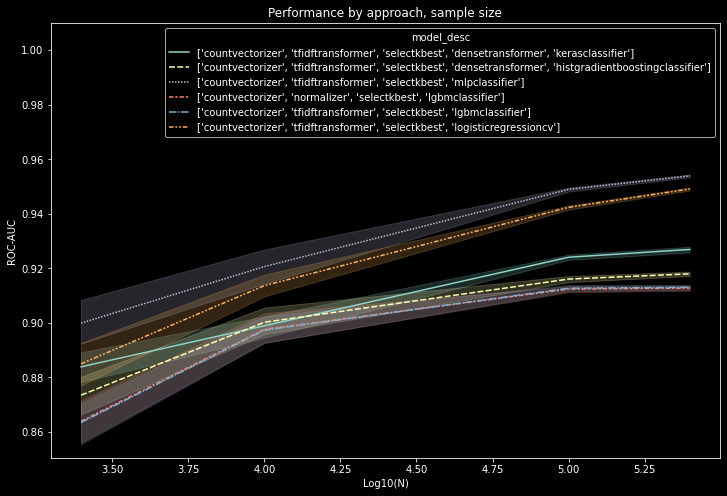

In [31]:
import seaborn as sns


perfs['log10_ss'] = np.log10(perfs.sample_size)

plt.figure(figsize=(12,8))
sns.lineplot(
    x='log10_ss',
    #hue='model_details',
    hue='model_desc',
    style='model_desc',
    y='roc_auc',
    data=perfs.reset_index(),
)
plt.title("Performance by approach, sample size")
plt.xlabel("Log10(N)")
plt.ylabel("ROC-AUC")
plt.ylim(None, 1.01)

top performers are multi-layer perceptron and LR, with MLP _maybe_ pulling ahead in the largest sample (250k) and LR ahead for smaller samples.  
other MLP (keras api with some limitations) does a bit worse, closely followed by a few different GBTs  
unsupervised dimensionality reduction with NMF lags behind 

non-lemmatized non-NMF .89-.94 ish AUC @ 250k examples  
add lemmatization: .85-.90! (degradation)  
switch to 2-grams (also drop NMF, slow + low perf): .?? AUC @ 250k examples

## train classical models on word embeddings (Word2Vec, Doc2Vec, Glove)  

these techniques have been around for a while and are often used to compare similarities, but we can also use them as features, puttinhg them on equal footing with around 2-300 components.  

Word2Vec and Doc2Vec are based on shallow NN, training on e.g. predicting words near each other in a text (over-simplified, but you get the idea), and Glove is trained on co-occurrences. we'll try a mix of pre-trained and custom-trained embeddings

#### glove pretrained

In [33]:
#!conda install -c anaconda gensim cython -y

In [37]:
import gensim
from gensim import downloader


# lots of opinions on Twitter, seems like a decent corpus to pretrain on.  
glove_vectorizer = downloader.load('glove-twitter-200')

[=-------------------------------------------------] 3.1% 23.4/758.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=================---------------------------------] 35.8% 271.4/758.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=========================-------------------------] 50.6% 383.4/758.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==========================------------------------] 53.1% 402.4/758.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===========================-----------------------] 55.7% 422.1/758.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=============================---------------------] 59.8% 453.2/758.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============================-------------------] 64.0% 485.4/758.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================----------------] 68.4% 519.1/758.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[====================================--------------] 72.9% 552.9/758.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================================] 100.0% 758.5/758.5MB downloaded


In [62]:
from gensim.parsing import preprocessing


def custom_preprocess(s: str) -> list[str]:
    processed = preprocessing.split_on_space(
        preprocessing.strip_short(
            preprocessing.strip_non_alphanum(
                preprocessing.strip_numeric(
                    preprocessing.lower_to_unicode(
                        s
                    )
                )
            )
        )
    )
    return processed

EXAMPLE_DOC = "we all live in a yellow submarine. it's deep underwater. i love it!"
custom_preprocess(EXAMPLE_DOC)



['all', 'live', 'yellow', 'submarine', 'deep', 'underwater', 'love']

In [68]:
def avg_pool_vectorize_doc(doc: str, word_vectorizer=glove_vectorizer):
    def try_vectorize(w):
        try:
            return word_vectorizer.get_vector(w)
        except KeyError:
            return None
    
    vectors = [
        try_vectorize(w) for w in custom_preprocess(doc)
    ]
    vectors = [
        v for v in vectors if v is not None
    ]
    avg_pooled_vector = np.mean(vectors, axis=0)
    return avg_pooled_vector

avg_pool_vectorize_doc(EXAMPLE_DOC).shape

(200,)

In [85]:
N = 100_000

embeddings = (
    reviews_train
        .head(N)
        .apply(lambda x: avg_pool_vectorize_doc(x['text']), axis=1, result_type='expand')
)

/home/jan/miniconda3/envs/2022-02/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jan/miniconda3/envs/2022-02/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [86]:
# now train on it.
cv = RepeatedStratifiedKFold(
    n_splits=5,
    n_repeats=2,
    random_state=42,
)
slice_aucs = cross_val_score(
    lrcv,
    embeddings.fillna(embeddings.mean()),
    reviews_train.rating.head(N),
    scoring='roc_auc',
    cv=cv,
    n_jobs=1,
)
round(np.mean(slice_aucs), 3)

0.897

even with pretrained model, hit .897 AUC - not bad. but keep in mind bag of n-grams got >.93.  

#### word2vec pretrained

In [87]:
# few options built in in Gensim, will settle for Google News :(
w2v_vectorizer = gensim.downloader.load("word2vec-google-news-300")


[--------------------------------------------------] 1.4% 23.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==------------------------------------------------] 4.9% 81.3/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[====----------------------------------------------] 8.5% 141.1/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[======--------------------------------------------] 12.1% 201.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======-------------------------------------------] 14.5% 241.8/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[========------------------------------------------] 16.5% 275.1/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=========-----------------------------------------] 18.7% 310.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==========----------------------------------------] 21.0% 349.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===========---------------------------------------] 23.2% 385.6/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[============--------------------------------------] 25.0% 416.1/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============-----------------------------------] 30.7% 510.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================--------------------------------] 36.3% 603.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================--------------------------------] 37.6% 625.8/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===================-------------------------------] 38.3% 637.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===================-------------------------------] 39.8% 661.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[======================----------------------------] 45.9% 763.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=========================-------------------------] 51.8% 861.3/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==========================------------------------] 53.0% 881.6/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===========================-----------------------] 54.0% 898.2/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[============================----------------------] 56.1% 932.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============================-------------------] 62.1% 1031.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============================-------------------] 63.8% 1061.6/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[================================------------------] 65.6% 1090.8/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=================================-----------------] 67.4% 1120.0/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================----------------] 69.1% 1149.3/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===================================---------------] 70.9% 1179.2/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[======================================------------] 77.9% 1295.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======================================-----------] 79.7% 1324.8/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==========================================--------] 84.6% 1407.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===========================================-------] 86.4% 1436.0/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[============================================------] 88.1% 1465.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=============================================-----] 90.7% 1507.3/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==============================================----] 93.1% 1548.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============================================---] 94.7% 1575.3/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=================================================-] 99.2% 1649.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [90]:
N = 100_000

embeddings = (
    reviews_train
        .head(N)
        .apply(
            lambda x: avg_pool_vectorize_doc(x['text'], word_vectorizer=w2v_vectorizer), 
            axis=1, 
            result_type='expand'
        )
)
# now train on it.
cv = RepeatedStratifiedKFold(
    n_splits=5,
    n_repeats=2,
    random_state=42,
)
slice_aucs = cross_val_score(
    lrcv,
    embeddings.fillna(embeddings.mean()),
    reviews_train.rating.head(N),
    scoring='roc_auc',
    cv=cv,
    n_jobs=1,
)
round(np.mean(slice_aucs), 3)

/home/jan/miniconda3/envs/2022-02/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jan/miniconda3/envs/2022-02/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.903

arguably a hair better, still far short of bag of words

### train doc2vec from scratch  

In [122]:
reviews_train.shape

(600000, 3)

In [123]:
FIRST_N = 500_000  # holdout last 100k of train for validation


def to_tagged_doc(row, col=TEXT_COL):
    return gensim.models.doc2vec.TaggedDocument(row[col], row.index)  # req arbitrary tag


def df_to_tagged_docs(df: pd.DataFrame, first_n) -> pd.Series:
    as_tagged_doc = (
        df.iloc[:FIRST_N]
            .apply(lambda row: custom_preprocess(row[TEXT_COL]), axis=1)  # preprocess
            .rename(TEXT_COL)  
            .to_frame()  # series -> frame with intended col name
            .apply(to_tagged_doc, axis=1)  # tagged doc type requires index, so use df index
    )
    return as_tagged_doc

In [124]:

custom_d2v_vectorizer = gensim.models.Doc2Vec(
    df_to_tagged_docs(reviews_train, FIRST_N),
    vector_size=200,
    min_count=10,  # of word to embed
    seed=42,
    workers=16,
    epochs=20,
)


In [127]:
custom_d2v_vectorizer.save("d2v_200.model")

In [129]:
custom_d2v_vectorizer.infer_vector([EXAMPLE_DOC])

array([ 1.7229655e-03, -2.1094044e-03,  1.9906173e-03,  1.2536144e-03,
       -1.7338947e-03, -2.8722748e-04,  1.6127158e-03, -2.0361738e-03,
        2.4160533e-03, -1.8149820e-03, -1.1454613e-03, -8.1594707e-04,
       -2.1636710e-03, -1.9222372e-03, -8.1704376e-04, -1.8155410e-04,
        1.8410296e-04, -1.5878560e-03, -9.4398571e-04, -3.4824834e-04,
        2.2947455e-03,  9.9231300e-05, -2.0724670e-03,  1.3037887e-03,
        2.2339269e-03,  1.2151322e-03, -5.0984800e-04, -1.9087463e-03,
       -5.3090020e-04, -2.3883970e-03, -2.3488232e-03,  1.7025146e-03,
        5.0059229e-04, -1.5752182e-04, -2.0743154e-03,  1.3401544e-03,
        1.4196835e-03,  1.1299431e-04,  4.4321359e-04, -3.0308680e-04,
       -8.4769708e-04, -1.1269340e-03, -1.4925433e-03, -9.2171860e-04,
       -1.9618720e-03, -1.8441267e-03,  8.1906706e-04,  5.9565005e-04,
        2.2172180e-03, -1.9765616e-04,  8.9189591e-04,  2.1521062e-04,
        2.1405825e-03, -2.2213701e-03, -1.7686748e-03,  1.5538299e-03,
      

In [160]:
N = 100_000

embeddings = (
    reviews_train.iloc[FIRST_N:FIRST_N + N][TEXT_COL]
        .apply(custom_preprocess)
        .apply(custom_d2v_vectorizer.infer_vector)
)
# series[ndarray] -> df
embeddings = pd.concat([pd.DataFrame(arr).transpose() for arr in embeddings], axis=0)

# now train on it.
cv = RepeatedStratifiedKFold(
    n_splits=5,
    n_repeats=2,
    random_state=42,
)
slice_aucs = cross_val_score(
    lrcv,
    embeddings.fillna(embeddings.mean()),
    reviews_train.rating.iloc[FIRST_N:FIRST_N + N],
    scoring='roc_auc',
    cv=cv,
    n_jobs=1,
)
round(np.mean(slice_aucs), 3)

0.863

worse than pretrained embeddings 

## transformer dnn  

goal here is not to deeply demonstrate the working of these models but to gain some very basic understanding + compare performance vs. classical approaches.  

a few methods I'm considering:
- document or sentence embeddings --> classical model  
- direct sentiment classification --> probability calibration (unlikely to work well, but a baseline)  
- fine-tune BERT or similar directly on our task  

In [13]:
# from flair.embeddings import TransformerDocumentEmbeddings

# # init embedding
# embedding = TransformerDocumentEmbeddings('distilbert-base-uncased')

# # create a sentence
# sentence = Sentence('The grass is green .')

# # embed the sentence
# embedding.embed(sentence)

### (naively) apply a pretrained (transformer) sentiment model

In [39]:
from transformers import pipeline


distilbert = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    tokenizer="distilbert-base-uncased-finetuned-sst-2-english",
    use_fast=True,
    padding=True, 
    truncation=True,
)

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized: ['dropout_139']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
distilbert('This is the worst restaurant in the world.')  # correct
distilbert('A meal that will change your life! A revelation!')  # correct
distilbert('This food is ok. I would eat if if I were stuck in an airport.')  # nope. overconfident

[{'label': 'NEGATIVE', 'score': 0.9997926354408264}]

[{'label': 'POSITIVE', 'score': 0.999808132648468}]

[{'label': 'POSITIVE', 'score': 0.9997032284736633}]

In [146]:
# since our model is already trained and we're just calibrating probability on top,
# we expect very small gains from increasing sample size.

reviews_tiny = reviews_train.head(5_000)
reviews_tiny['distilbert_sentiment'] = distilbert(reviews_tiny.text.tolist())  # req List not ndarray

reviews_tiny['distilbert_proba_positive'] = [
    d.get('score') if d.get('label') == 'POSITIVE' 
    else (1 - d.get('score')) 
    for d in reviews_tiny['distilbert_sentiment']
]

/tmp/ipykernel_10614/3873412606.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_tiny['distilbert_sentiment'] = distilbert(reviews_tiny.text.tolist())  # req List not ndarray
/tmp/ipykernel_10614/3873412606.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_tiny['distilbert_proba_positive'] = [


In [148]:
# now train on it.
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    C=1e-2,  # basically turn off regularization, one feature
)

cv = RepeatedStratifiedKFold(
    n_splits=5,
    n_repeats=2,
    random_state=42,
)
slice_aucs = cross_val_score(
    lr,
    reviews_tiny['distilbert_proba_positive'].to_frame(),
    reviews_tiny['rating'],
    scoring='roc_auc',
    cv=cv,
    n_jobs=1,
)
round(np.mean(slice_aucs), 3)

0.904

__.904 AUC from an applying an untuned pretrained sentiment model in pretty much the most naive way possible isn't bad!__  

### Use Sentence-BERT Sentence Embeddings   

more elegant to build sentence-level embeddings than pool over word embeddings with e.g. mean or max. because I don't have a farm of GPUs, we'll load a pretrained model, produce per-example sentence embeddings, and fit a simple-but-reasonable-for-nlp model on top (LR CV).  

ref - https://www.sbert.net/  

In [8]:
from sentence_transformers import SentenceTransformer


sentence_transformer = SentenceTransformer(
    'paraphrase-MiniLM-L6-v2'
)

sentences = [
    'I saw ten cockroaches while I was eating, and my food tasted like drool.',
    'Angels came down from the heavens when I placed the first delicious bite in my mouth.',
    'My food tasted like food, and it was fine.'
]

#Sentences are encoded by calling model.encode()
embeddings = sentence_transformer.encode(sentences)

Ignored unknown kwarg option direction


In [7]:
embeddings[0].shape

(384,)

In [12]:
pd.DataFrame(embeddings)

0         1         2         3         4         5         6    \
0 -0.176214  0.120601 -0.293624 -0.229858 -0.082293  0.237710  0.339985   
1  0.322088 -0.001239  0.179374 -0.369192 -0.064603  0.091537  0.241191   
2  0.589794 -0.235984 -0.254117  0.003116 -0.084857 -0.267997 -0.075067   

        7         8         9    ...       374       375       376       377  \
0 -0.780965  0.118128  0.163374  ...  0.199122 -0.280674  0.434193 -0.140275   
1 -0.294942  0.077290  0.115770  ...  0.034437  0.187955  0.200372 -0.053560   
2 -0.300214  0.051517  0.165853  ...  0.038432 -0.070905 -0.174045 -0.448594   

        378       379       380       381       382       383  
0  0.578049  0.177716  0.089836  0.329652  0.061301 -0.324933  
1  0.284853  0.071766  0.054871 -0.081038  0.270769  0.117003  
2 -0.318672  0.416560 -0.054316  0.140362  1.055916  0.530181  

[3 rows x 384 columns]

In [28]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegressionCV

In [37]:
N = 100_000
TEXT_COL = 'text'  # wants raw, not tokenized or cleaned.

embeddings = pd.DataFrame(
    sentence_transformer.encode(
        reviews_train.loc[:N, TEXT_COL]
    )
)

# now train on it.
cv = RepeatedStratifiedKFold(
    n_splits=5,
    n_repeats=2,
    random_state=42,
)
slice_aucs = cross_val_score(
    lrcv,
    embeddings,
    reviews_train.rating.loc[:N],
    scoring='roc_auc',
    cv=cv,
    n_jobs=1,
)
round(np.mean(slice_aucs), 3)

Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg opt

0.897

In [42]:
slice_aucs = cross_val_score(
    mlp_skl,
    embeddings,
    reviews_train.rating.loc[:N],
    scoring='roc_auc',
    cv=cv,
    n_jobs=1,
)
round(np.mean(slice_aucs), 3)

0.904

.90 ish AUC, very similar to our other embeddings  

### Use Distilbert Embeddings in a Classical Model  

Idea: extract avg pooled embeddings across words in a sentence. Note: this is probably a worse idea than using a customized sentence embedding approach as with SentenceBERT above, and the authors of that paper suggest this might even be worse than averaging Glove vectors! (ref: https://arxiv.org/pdf/1908.10084.pdf)  

so i'll skip for now.

In [44]:
from transformers import TFAutoModelForSequenceClassification
import tensorflow as tf
from transformers import AutoTokenizer


MODEL_STR = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(
    #"distilbert-base-uncased",
    MODEL_STR,
    use_fast=True,
)
model = TFAutoModelForSequenceClassification.from_pretrained(
    MODEL_STR, num_labels=2, output_hidden_states=True,
)

2022-02-16 12:18:37.291317: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-16 12:18:37.291945: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-02-16 12:18:37.291977: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:0b:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.725GHz coreCount: 82 deviceMemorySize: 24.00GiB deviceMemoryBandwidth: 871.81GiB/s
2022-02-16 12:18:37.292027: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-02-16 12:18:37.292055: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-02-16 12:18:37.292084: I tensorflow/stream_executor/pl

In [45]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
import torch


assert(torch.cuda.is_available())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

# managed to get TF GPU configured with WSL, will need to do so for pytorch eventually

NVIDIA GeForce RTX 3090


we will fine-tune so warnings are fine

In [117]:
encoded_input = tokenizer(
    "I love this restaurant.", 
    return_tensors='tf',
    padding=False,
    truncation=True,
    max_length=511,
) 
output = model(encoded_input)
#output.values()

In [64]:
encoded_input

{'input_ids': <tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[ 101, 1045, 2293, 2023, 4825, 1012,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [65]:
len(output.hidden_states)
# believe each of this is activation of a given layer.


7

In [66]:
# extract embeddings from the last layer by averaging across each word embedding
# (common practice, though not necessarily ideal vs. directly embedding sentences or docs)
tf.math.reduce_mean(
    output.hidden_states[-1], axis=1
)  

<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[ 4.01792794e-01,  1.68802351e-01,  1.71388481e-02,
         6.49228320e-02,  4.09759969e-01, -3.33880335e-01,
        -4.60332595e-02,  7.30314374e-01, -1.44461438e-01,
        -2.06000373e-01,  2.02904493e-02, -4.14972335e-01,
        -9.32289287e-02,  5.36350369e-01, -1.47600686e-02,
         1.64310247e-01,  2.84710258e-01,  2.03436330e-01,
         5.07316412e-03,  2.38363951e-01,  3.29528898e-01,
        -2.68845946e-01, -2.66143471e-01,  4.40286785e-01,
         1.49239346e-01, -7.58815631e-02, -1.91445559e-01,
         7.48202875e-02,  5.11089005e-02, -3.09779346e-01,
         2.34540865e-01, -1.43738106e-01, -1.65629044e-01,
        -8.54006335e-02, -1.65757369e-02, -3.06997031e-01,
        -1.01898052e-01, -2.40175560e-01, -5.39553225e-01,
         6.28336193e-03, -1.99288025e-01, -2.79022306e-01,
         3.40499192e-01,  7.90226012e-02, -1.41758826e-02,
        -4.35192972e-01, -3.72978635e-02,  1.52611017e-01,
      

In [93]:
N = 100_000

reviews_tiny = reviews_train.copy().iloc[:N]


In [95]:
# now get embeddings for all of our training data

#encoded_input = tokenizer(reviews_tiny.text.head(10).tolist())  # req List not ndarray

# todo - have to do something like this? doesn't just take a list
#from datasets import Dataset

#reviews_tiny_ds = Dataset.from_pandas(reviews_tiny)

# Interface easiest on a per-row basis, though I'd rather avoid the `apply`

def tokenize(s: str, tokenizer=tokenizer):
    tokenized = tokenizer(
        s,
        return_tensors='tf',
        padding=False,
        truncation=True,
        max_length=511,
        verbose=False,
    )
    return tokenized


tokenized = reviews_tiny[TEXT_COL].apply(tokenize)



#embeddings = tf.math.reduce_mean(
#    output.hidden_states[-1], axis=1
#)  

Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg opt

In [97]:
#model.predict(
tokenized[0]

{'input_ids': <tf.Tensor: shape=(1, 155), dtype=int32, numpy=
array([[  101,  1045,  3030,  1999,  2090,  6521,  2012,  1037,  3034,
         2012,  1996, 15510,  1012,  2009,  2165,  1996,  2878,  2382,
         2781,  1045,  2018,  2800,  2000,  2344,  1998,  3477,  1012,
         1032,  1050,  1032,  9152,  3641,  1996,  7163,  2601,  7967,
         9587, 17854,  2063,  1010,  2029,  2246,  2307,  1999,  1996,
         3573,  1010,  2021,  2011,  1996,  2051,  1045,  2288,  2009,
         2067,  2000,  2026,  2282,  2044,  2019,  3178,  2146,  3034,
         5219,  1010,  2009,  2001, 12501,  1998,  4895,  2890,  3597,
        29076,  4143,  3468,  2009,  2036,  2357, 12579,  1999,  1996,
         3482,  1010,  1998,  7967, 15748,  2041,  1010,  2437,  1037,
         2978,  1997,  6752,  1012,  1032,  1050,  1032,  9152,  2036,
         3641,  1996, 16876,  8808, 17955,  2029,  2106,  2488,  1012,
         1032,  1050,  1032,  9152,  2546,  2017,  2272,  2182,  1010,
         1045, 

In [98]:
# likewise, wants elem-wise apply


def avg_pool_embed_bert(tokens, model=model):
    output = model(tokens)
    embedding = tf.math.reduce_mean(
        output.hidden_states[-1], axis=1
    )  
    return embedding


output = tokenized.apply(avg_pool_embed_bert)
embeddings = pd.concat([pd.DataFrame(arr) for arr in output], axis=0)

In [99]:
embeddings

0         1         2         3         4         5         6    \
0  -0.118352 -0.008283  0.257049  0.160720  0.249403  0.068509  0.032527   
0  -0.158772 -0.035368  0.308919  0.119636  0.427324 -0.103732  0.042862   
0  -0.127352  0.058976  0.187174  0.127615  0.234510  0.029373 -0.026324   
0  -0.059529  0.079816  0.250397  0.194327  0.262242 -0.016016 -0.047956   
0  -0.111995  0.079079  0.284658 -0.039781  0.243875 -0.050971  0.068567   
..       ...       ...       ...       ...       ...       ...       ...   
0   0.105027  0.044867  0.204148  0.155107  0.329069 -0.160717 -0.026159   
0  -0.097272 -0.036362  0.089551  0.239596  0.182783 -0.022534 -0.108661   
0   0.158744  0.006377  0.219775  0.244834  0.405541 -0.127196 -0.118161   
0  -0.155253 -0.047561  0.326955  0.043298  0.328428 -0.064925 -0.006498   
0  -0.090739  0.242030  0.401504 -0.018234  0.112957 -0.102969  0.211010   

         7         8         9    ...       758       759       760       761  \
0   0.574636  0.008210 -0.137210  ... -0.257369 -0.071568  0.064799 -0.262440   
0   0.683936  0.040087 -0.151254  ... -0.118453 -0.086378  0.047386 -0.188533   
0   0.656135  0.062625 -0.195146  ... -0.263349 -0.022270  0.119420 -0.225303   
0   0.586685 -0.008625 -0.155121  ... -0.281717 -0.123293  0.163535 -0.176205   
0   0.639531  0.051526 -0.223243  ... -0.113906 -0.199588  0.015935 -0.266181   
..       ...       ...       ...  ...       ...       ...       ...       ...   
0   0.941686  0.060029 -0.238109  ... -0.109879 -0.122029 -0.189579 -0.257359   
0   0.666454  0.084426 -0.113913  ... -0.291361 -0.099682  0.001714 -0.177613   
0   0.746183  0.074941 -0.189778  ... -0.184695 -0.083105 -0.072652 -0.106019   
0   0.617248  0.024427 -0.271315  ... -0.171430 -0.148914  0.122812 -0.216131   
0   0.511119 -0.001279 -0.294118  ... -0.108915 -0.112158  0.018174 -0.342508   

         762       763       764       765       766       767  
0  -0.161612 -0.182044 -0.129858 -0.030688  0.024741  0.159159  
0  -0.133722 -0.067322  0.038893  0.067550  0.112650  0.142516  
0  -0.145068 -0.273589 -0.159653  0.049516  0.159782  0.027455  
0  -0.241085 -0.127287  0.023781  0.043556  0.215549 -0.100278  
0  -0.162724 -0.177525 -0.077712  0.089766  0.133474  0.029526  
..       ...       ...       ...       ...       ...       ...  
0  -0.151362 -0.119338  0.045966  0.095944  0.264599  0.049690  
0  -0.176777 -0.132715 -0.054045  0.100055  0.164692 -0.095254  
0  -0.018130 -0.094236 -0.247595 -0.008502  0.175670 -0.054132  
0  -0.228520 -0.189252  0.000032 -0.057631  0.142314  0.031662  
0  -0.100211 -0.266260 -0.269321 -0.009161  0.095027  0.166242  

[100000 rows x 768 columns]

In [101]:
slice_aucs = cross_val_score(
    mlp_skl,
    embeddings,
    reviews_tiny.rating,
    scoring='roc_auc',
    cv=cv,
    n_jobs=1,
)
round(np.mean(slice_aucs), 3)

0.94

surprisingly good performance, just shy of MLP on bag-of-n-grams @ .95 ish AUC for n=100k. 

approach has some similarities w/ fine-tuning, TBH, since we're stacking a small, dense NN on top of our embeddings.  

### Fine-tune (distil)BERT on our task  

In [53]:
# copypasta + modified from https://huggingface.co/docs/transformers/custom_datasets  
from transformers import AutoTokenizer
from datasets import Dataset


tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_str(ds: Dataset, col: str = 'text', tokenizer = tokenizer):
    return tokenizer(ds[col], truncation=True, padding=True)


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /home/jan/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.16.2",
  "vocab_size": 30522
}

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /home/jan/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3

In [54]:
N = 110_000  # validate on 20k sample, train on 100k, (test on 100k)


reviews_train['label'] = reviews_train.rating.copy(deep=True).astype('int8')
reviews_sample = Dataset.from_pandas(reviews_train.copy().iloc[:N][['text', 'label']])

/tmp/ipykernel_25705/1149016540.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_train['label'] = reviews_train.rating.copy(deep=True).astype('int8')


In [55]:
reviews_sample

Dataset({
    features: ['text', 'label'],
    num_rows: 110000
})

In [56]:
tokenized = reviews_sample.map(preprocess_str, batched=True)


  0%|          | 0/110 [00:00<?, ?ba/s]

Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg opt

In [57]:
from transformers import DataCollatorWithPadding


data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [58]:
from transformers import AutoModelForSequenceClassification


model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /home/jan/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.16.2",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /home/jan/.cache/huggingface/transformers/9c169

warnings are fine, since we will be fine-tuning

In [59]:
tokenized

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 110000
})

In [60]:
train_test = tokenized.train_test_split(test_size=10_000, shuffle=True, seed=42)

train_test

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 10000
    })
})

In [61]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score


BATCH_SZ = 16
GRADIENT_STEPS = 8


# def compute_metrics(p):    
#     print(p)
#     probas, labels = p
#     print(probas)
#     print(labels)
#     #proba_1 = probas[1]
#     pred = np.argmax(probas, axis=1)
    
#     accuracy = accuracy_score(y_true=labels, y_pred=pred)
#     f1 = f1_score(y_true=labels, y_pred=pred)
    
#     # warn: we often don't expect DL model to produce well-calibrated probas, 
#     #       but this is fine given a rank-based metric.
#     #roc_auc = roc_auc_score(labels, proba_1)
    
#     metrics = {
#         "accuracy": accuracy, "f1": f1, "roc_auc": -1,# roc_auc,
#     } 
#     return metrics

print('foo')

# see incredibly long api docs @
# https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments
training_args = TrainingArguments(
    label_names=['label'],
    output_dir="./results",
    overwrite_output_dir=True,
    optim='adamw_hf',
    learning_rate=2e-5,
    # see https://github.com/huggingface/transformers/issues/14608#issuecomment-1004390803  
    per_device_train_batch_size=BATCH_SZ,  # linear speedup w/ batch size with slight caveats
    per_device_eval_batch_size=BATCH_SZ,
    gradient_accumulation_steps=GRADIENT_STEPS,
    num_train_epochs=5,
    #load_best_model_at_end = True,
    #save_strategy=BATCH_SZ * GRADIENT_STEPS,  # for early stopping, need same save + eval
    save_strategy='epoch',                    # else if not early stopping, can checkpoint less often
    logging_steps=2 * BATCH_SZ * GRADIENT_STEPS,
    eval_steps=2 * BATCH_SZ * GRADIENT_STEPS,
    evaluation_strategy="steps",
    save_total_limit=3,
    weight_decay=0.01,
    log_level='debug',
    logging_first_step=True,
    report_to='all',
    # few settings for speed
    bf16=True,  # need to upgrade from CUDA 10.x to 11.x
    tf32=True,  # need to upgrade from CUDA 10.x to 11.x
    group_by_length=True,
    seed=42,
)
# note: on my 3090, using bf16,tf32,8 gradient steps and CUDA 11.x (vs. 10.x) is way faster, >2x speedup  
# and smart padding (`group_by_length`) yields another ~2x speedup!
print('foo')

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_test['train'],
    eval_dataset=train_test['test'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    #compute_metrics=compute_metrics,
    #callbacks=[EarlyStoppingCallback(early_stopping_patience = 3)],
)
print('foo')
trainer.train()

PyTorch: setting up devices
Using amp half precision backend
The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.


foo
foo
foo


/home/jan/miniconda3/envs/just-pytorch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 100000
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 8
  Total optimization steps = 3905


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 16
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 16
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-781
Configuration saved in ./results/checkpoint-781/config.json
Model weights saved in ./results/checkpoint-781/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-781/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-7

TrainOutput(global_step=3905, training_loss=0.17702170028881897, metrics={'train_runtime': 3768.2339, 'train_samples_per_second': 132.688, 'train_steps_per_second': 1.036, 'total_flos': 6.622946037124301e+16, 'train_loss': 0.17702170028881897, 'epoch': 5.0})

In [84]:
#trainer.evaluate(train_test['test'].map(preprocess_str, batched=True))

In [83]:

preds = trainer.predict(
    train_test['test'].remove_columns(['text', 'label'])
)

***** Running Prediction *****
  Num examples = 10000
  Batch size = 16


In [95]:
preds.predictions.shape

(10000, 2)

In [108]:
from sklearn.model_selection import cross_val_score


slice_aucs = cross_val_score(
    mlp_skl,
    preds.predictions,
    train_test['test']['label'],
    scoring='roc_auc',
    cv=cv,
    n_jobs=1,
)
round(np.mean(slice_aucs), 3)

0.968

best performance yet! admittedly took a non-trivial effort to outdo bag-of-ngrams (and simple bag-of-words was very close), but we finally got there.  

note: we could predict on new data with huggingface transfomers pipeline class

In [20]:
encoded_input = tokenizer(
    "I love this restaurant.", 
    #return_tensors='pt',
    #padding=False,
    truncation=True,
    max_length=511,
) 
output = model.(encoded_input)

Ignored unknown kwarg option direction


AttributeError: 

__old tensorflow code to kill__

In [102]:
from transformers import TFAutoModelForSequenceClassification
#import tensorflow as tf
from transformers import AutoTokenizer


MODEL_STR = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(
    #"distilbert-base-uncased",
    MODEL_STR,
    use_fast=True,
)
model = TFAutoModelForSequenceClassification.from_pretrained(
    MODEL_STR, num_labels=2, output_hidden_states=True,
)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_39', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [106]:
reviews_tiny.rating = reviews_tiny.rating.astype('int8')
reviews_tiny
tf.convert_to_tensor(reviews_tiny)

rating                                               text  ord_rating
0           0  I stopped in between sessions at a conference ...           3
1           1  The Seafarer, like all Southern \"Fish Camps\"...           4
2           1  It's normal to travel 370 miles specifically f...           5
3           0  We went on Saturday night to satiate my cravin...           3
4           0  My husband and I were headed to Mellow Mushroo...           2
...       ...                                                ...         ...
99995       0  nothing special to report about this place... ...           3
99996       0  Great mojito.\n\nWent for a light dinner.  One...           3
99997       0  Overpriced under good. Service was great but t...           2
99998       1  Looking for the perfect thin crust pizza? Well...           4
99999       1  Took myself cuz I didn't feel I was getting be...           4

[100000 rows x 3 columns]

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [107]:
reviews_tiny.dtypes

rating          int8
text          object
ord_rating      int8
dtype: object

In [111]:
from transformers import DataCollatorForTokenClassification


data_collator = DataCollatorForTokenClassification(
    tokenizer=tokenizer,
    padding=False,
    max_length=511,
    return_tensors='tf',
)

In [116]:
from nlp import Dataset

reviews_tiny_ds = Dataset.from_pandas(reviews_tiny)

# .to_tf_dataset(
#     columns= reviews_tiny.columns.tolist(),
#     shuffle=False,
#     batch_size=32,
#     collate_fn=data_collator,
# )

In [ ]:
#reviews_tiny_ds.set_format()

In [121]:
#!conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch -y

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: | 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
Examining conflict for pyarrow arrow-cpp parquet-cpp:  84%|▊| 285/340 [3:33:11/ 

In [ ]:
from transformers import create_optimizer

num_train_steps = len(tf_train_dataset) * num_train_epochs
5 optimizer, lr_schedule = create_optimizer(
6     init_lr=learning_rate,
7     num_train_steps=num_train_steps,
8     weight_decay_rate=weight_decay_rate,
9     num_warmup_steps=num_warmup_steps,
10 )
11 
12 model = TFAutoModelForTokenClassification.from_pretrained(
13     model_id,
14     id2label=id2label,
15     label2id=label2id,
16 )
17 
model.compile(optimizer=optimizer)


In [36]:
reviews_text_tiny = tf.convert_to_tensor(reviews_train.text.iloc[-1000:])
labels_tiny = tf.convert_to_tensor(reviews_train.rating.iloc[-1000:])


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)

model.fit(train_tf_dataset, validation_data=eval_tf_dataset, epochs=3)